In [26]:
from scheduling_functions import *
from scheduling_algorithms import *
import numpy as np
import sys
import copy
from random import sample, randint, seed
from math import isclose, ceil, floor
from statistics import mean
from decimal import *
from fractions import *
import matplotlib.pyplot as plt
import dill
from DataGeneration import *

In [27]:
#returns the energy ratio AVR_energy/Optimal_energy

def AVR_energy_ratio(_J, alpha):
    
    J = copy.deepcopy(_J)
    #speed list of average rate
    AVR_speed_list = Avg_rate(J)
    #energy consumption of AVR
    energy_AVR = computeEnergy(AVR_speed_list, alpha)
    
    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = computeEnergy(optimal_alg_speed_list, alpha)  
    
    return float(energy_AVR)/energy_optimal    

In [28]:
#returns the energy ratio OA_energy/Optimal_energy

def OA_energy_ratio(_J, alpha):
    
    J = copy.deepcopy(_J)
    #speed list of Optimal Available
    OA_speed_list = OptimalOnline(J)
    #energy consumption of Optimal Available
    energy_OA = sum([s**alpha for s in OA_speed_list])
    
    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = computeEnergy(optimal_alg_speed_list, alpha)    
   
    return float(energy_OA)/energy_optimal

In [29]:
def yds_m_energy_ratio(_J, m, alpha):
    J = copy.deepcopy(_J)
    yds_speed_list = yds_M(J, m)
    energy_yds_m = computeEnergy(yds_speed_list, alpha)

    J = copy.deepcopy(_J)
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    energy_optimal = computeEnergy(optimal_alg_speed_list, alpha)

    return float(energy_yds_m)/energy_optimal


In [30]:
def LAS_energy_ratio(_J_true, _J_pred, epsilon, alpha, dt):
    
    #compute energy of LAS algorithm
    J_true = copy.deepcopy(_J_true)
    J_pred = copy.deepcopy(_J_pred)
    
    # Create a 3-element version of J_pred for LAS
    J_pred_for_LAS = {}
    for job_id, job_data in J_pred.items():
        J_pred_for_LAS[job_id] = (job_data[0], job_data[1], job_data[2])

    speed_sol = LAS(J_pred_for_LAS, J_true, epsilon, dt, alpha)
    energy_LAS = sum([s**alpha for s in speed_sol])*dt
    
   
    #compute speedlist and energu consumption of the optimal schedule of the true instance
    J_true = copy.deepcopy(_J_true)
    J_pred = copy.deepcopy(_J_pred)
    optimal_alg_speed_list, _ = Optimal_Alg(J_true)
    energy_optimal = computeEnergy(optimal_alg_speed_list, alpha)
    
    return float(energy_LAS)/energy_optimal    

In [31]:
def DCRR_energy_ratio(_J, m, alpha):
    J = copy.deepcopy(_J)
    dcrr_speed_list = DCRR(J, m)
    energy_DCRR = computeEnergy(dcrr_speed_list, alpha)

    J = copy.deepcopy(_J)
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    energy_optimal = computeEnergy(optimal_alg_speed_list, alpha)

    return float(energy_DCRR/energy_optimal)


In [32]:
def SWP_m_energy_ratio(_J_true, _J_pred, m, _epsilon, dt, alpha, confThreshold):
    J_true = copy.deepcopy(_J_true)
    J_pred = copy.deepcopy(_J_pred)
    swp_m_speed_list = swp_m(J_true, J_pred, m, _epsilon, dt, alpha, confThreshold)
    energy_swp_m = sum([s**alpha for s in swp_m_speed_list]) * dt

    J_true = copy.deepcopy(_J_true)
    optimal_alg_speed_list, _ = Optimal_Alg(J_true)
    energy_optimal = computeEnergy(optimal_alg_speed_list, alpha)

    return float(energy_swp_m)/energy_optimal


In [33]:
def create_input(jobs_list, include_pred_conf=False):
    res = {}
    for i, job_data in enumerate(jobs_list):
        weight, arrival, deadline, predConf = job_data
        if include_pred_conf:
            res[i + 1] = (weight, arrival, deadline, predConf)
        else:
            res[i + 1] = (weight, arrival, deadline)
    return res

In [34]:

# Revise data generation logic in Cell 7 to simulate 10,000 days with 1-144 jobs per day using jobsWithPred.

num_simulated_days = 25 # Target number of simulated days
T_param = 144 # Max jobs per day, also serves as time horizon for each day
D_param = 20 # Deadline parameter for jobsWithPred

dates_dict = {}

for day_idx in range(num_simulated_days):
    # Randomly determine the number of jobs for this day (1 to 144)
    num_jobs_today = randint(40, 144)
    
    # Generate jobs for this day. Arrival and deadline are relative to the start of the day.
    # We'll adjust them to be absolute later if needed, but for now, jobsWithPred handles relative times.
    daily_jobs = jobsWithPred(num_jobs_today, T_param, D_param)
    
    # Store the generated jobs as a list of tuples under the current simulated date
    dates_dict[day_idx] = sorted(list(daily_jobs.values()), key=lambda k : k[1])

print(f"Generated data for {len(dates_dict)} simulated days.")

Generated data for 25 simulated days.


In [35]:
for date in sorted(dates_dict.keys()):
    dates_dict[date].sort(key=lambda x: x[1])  # Sort by arrival time (index 1)

num_of_days = len(dates_dict)
print(f"Number of simulated days: {num_of_days}")

Number of simulated days: 25


In [36]:
dates_lst = []
for date in sorted(dates_dict.keys()):
    dates_lst.append(date)

In [37]:
D = 20
dt = 0.01
alphas = [3, 6, 9, 12]
epsilons = [Fraction(1, 100), Fraction(80, 100)]
m = 10

In [38]:
y_SWP_m = {}
y_AVR = []
y_OA = []
y_DCRR = []
y_yds_m = []
y_LAS = {}
alpha = alphas[0]
for epsilon in epsilons:
    y_SWP_m[epsilon] = []
    y_LAS[epsilon] = []

for day_idx in dates_lst:
    print(f"day= {day_idx}")
    
    # Use the same day's data for both J_true and J_pred
    raw_day_data = dates_dict[day_idx]
    
    J_pred = create_input(raw_day_data, include_pred_conf=True)
    J_true = create_input(raw_day_data, include_pred_conf=False)

    AVR = AVR_energy_ratio(J_true, alpha)
    OA = OA_energy_ratio(J_true, alpha)
    dcrr_ratio = DCRR_energy_ratio(J_true, m, alpha)
    yds_m_ratio = yds_m_energy_ratio(J_true, m, alpha)
    print("AVG = ", AVR)
    y_AVR.append(AVR)

    print("OA = ", OA)
    y_OA.append(OA)
    
    print("DCRR= ", dcrr_ratio)
    y_DCRR.append(dcrr_ratio)

    print("YDS_m = ", yds_m_ratio)
    y_yds_m.append(yds_m_ratio)
    
    for epsilon in epsilons:
        SWP_m = SWP_m_energy_ratio(J_true, J_pred, m, epsilon, dt, alpha, 0.5)
        LAS_ratio = LAS_energy_ratio(J_true, J_pred, epsilon, alpha, dt)
        print("SWP_m, epsilon=", epsilon, "--->", SWP_m)
        print("LAS Scheduling, epsilon=", epsilon, "--->", LAS_ratio)
        y_SWP_m[epsilon].append(SWP_m)
        y_LAS[epsilon].append(LAS_ratio)
        
    print("====================")


day= 0
AVG =  1.4515573034803146
OA =  2.7378494438689436
DCRR=  0.034609865302537665
YDS_m =  0.025700113826126306
SWP_m, epsilon= 1/100 ---> 0.4315518515440542
LAS Scheduling, epsilon= 1/100 ---> 0.28122483027154194
SWP_m, epsilon= 4/5 ---> 0.47219643789123306
LAS Scheduling, epsilon= 4/5 ---> 0.30437868971434956
day= 1
AVG =  1.429594217314359
OA =  5.121134217132523
DCRR=  0.060571382126257615
YDS_m =  0.03886171261230067
SWP_m, epsilon= 1/100 ---> 0.6857207213206662
LAS Scheduling, epsilon= 1/100 ---> 0.277270690869106
SWP_m, epsilon= 4/5 ---> 0.6968088131299934
LAS Scheduling, epsilon= 4/5 ---> 0.3001805554109552
day= 2
AVG =  1.2509596151919804
OA =  0.8232199761565626
DCRR=  0.01567859605521352
YDS_m =  0.01239312996236894
SWP_m, epsilon= 1/100 ---> 0.3172602252301314
LAS Scheduling, epsilon= 1/100 ---> 0.28952645943182154
SWP_m, epsilon= 4/5 ---> 0.3467450139266757
LAS Scheduling, epsilon= 4/5 ---> 0.31336381028084376
day= 3
AVG =  1.361482997765213
OA =  1.8388183919955112
DC

In [39]:
print("AVR has mean competitive ratio of :", mean(y_AVR))
print("The worst competitive ratio of AVR is : ", max(y_AVR))

print("OA has mean competitive ratio of :", mean(y_OA))
print("The worst competitive ratio of  OA is : ", max(y_OA))

print("DCRR has mean competitive ratio of :" , mean(y_DCRR))
print("The worst competitive ratio of DCRR is : ", max(y_DCRR))

print("YDS_M has mean competitive ratio of : ", mean(y_yds_m))
print("The worst competitive ratio of YDS_M is : ", max(y_yds_m))
print("==========================================")

for epsilon in epsilons:
    print("LAS for epsilon", epsilon, " has the mean comptitive ratio of :" , mean(y_LAS[epsilon]))
    print("The worst competitive ratio of LAS for epsilon", epsilon, " is : ", max(y_LAS[epsilon]))


    print("SWP_m for epsilon", epsilon, " has the mean comptitive ratio of :" , mean(y_SWP_m[epsilon]))
    print("The worst competitive ratio of SWP_m for epsilon", epsilon, " is : ", max(y_SWP_m[epsilon]))

    print("==============================================")


AVR has mean competitive ratio of : 1.4102691536282979
The worst competitive ratio of AVR is :  1.713641750235153
OA has mean competitive ratio of : 2.516093164880792
The worst competitive ratio of  OA is :  5.121134217132523
DCRR has mean competitive ratio of : 0.03272594377321658
The worst competitive ratio of DCRR is :  0.07806532886559751
YDS_M has mean competitive ratio of :  0.023268214273427866
The worst competitive ratio of YDS_M is :  0.05867697227864394
LAS for epsilon 1/100  has the mean comptitive ratio of : 0.2699609884754982
The worst competitive ratio of LAS for epsilon 1/100  is :  0.28978347012238165
SWP_m for epsilon 1/100  has the mean comptitive ratio of : 0.4113667998527032
The worst competitive ratio of SWP_m for epsilon 1/100  is :  0.6857207213206662
LAS for epsilon 4/5  has the mean comptitive ratio of : 0.2931643574731211
The worst competitive ratio of LAS for epsilon 4/5  is :  0.31364255364829574
SWP_m for epsilon 4/5  has the mean comptitive ratio of : 0.44

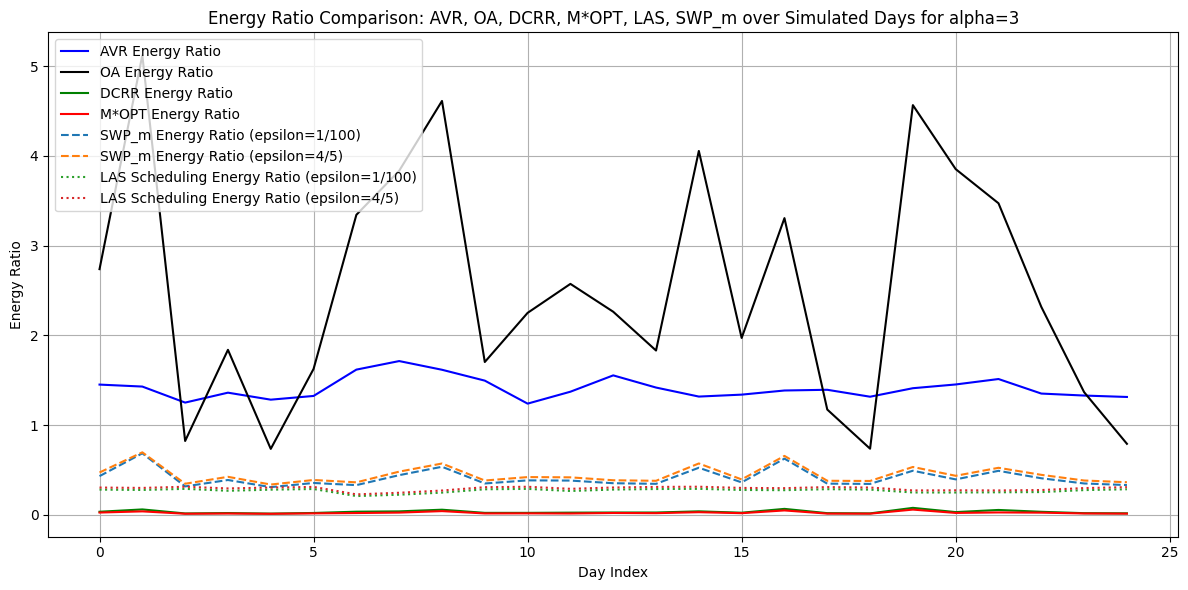

In [40]:
# Create a list of day indices for plotting
day_indices = list(range(len(y_AVR)))

plt.figure(figsize=(12, 6))
plt.plot(day_indices, y_AVR, label='AVR Energy Ratio', color='blue')
plt.plot(day_indices, y_OA, label='OA Energy Ratio', color='black')
plt.plot(day_indices, y_DCRR, label='DCRR Energy Ratio', color='green')
plt.plot(day_indices, y_yds_m, label='M*OPT Energy Ratio', color='red')

# Assuming y_SWP_m is a dictionary with epsilon as keys, and each value is a list of ratios
for epsilon, ratios in y_SWP_m.items():
    plt.plot(day_indices, ratios, label=f'SWP_m Energy Ratio (epsilon={epsilon})', linestyle='--')

for epsilon, ratios in y_LAS.items():
    plt.plot(day_indices, ratios, label=f'LAS Scheduling Energy Ratio (epsilon={epsilon})', linestyle=':')

plt.xlabel('Day Index')
plt.ylabel('Energy Ratio')
plt.title('Energy Ratio Comparison: AVR, OA, DCRR, M*OPT, LAS, SWP_m over Simulated Days for alpha=3')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
y_SWP_m = {}
y_AVR = []
y_OA = []
y_DCRR = []
y_yds_m = []
y_LAS = {}
alpha = alphas[1]
for epsilon in epsilons:
    y_SWP_m[epsilon] = []
    y_LAS[epsilon] = []

for day_idx in dates_lst:
    print(f"day= {day_idx}")
    
    # Use the same day's data for both J_true and J_pred
    raw_day_data = dates_dict[day_idx]
    
    J_pred = create_input(raw_day_data, include_pred_conf=True)
    J_true = create_input(raw_day_data, include_pred_conf=False)

    AVR = AVR_energy_ratio(J_true, alpha)
    OA = OA_energy_ratio(J_true, alpha)
    dcrr_ratio = DCRR_energy_ratio(J_true, m, alpha)
    yds_m_ratio = yds_m_energy_ratio(J_true, m, alpha)
    print("AVG = ", AVR)
    y_AVR.append(AVR)

    print("OA = ", OA)
    y_OA.append(OA)
    
    print("DCRR= ", dcrr_ratio)
    y_DCRR.append(dcrr_ratio)

    print("YDS_m = ", yds_m_ratio)
    y_yds_m.append(yds_m_ratio)
    
    for epsilon in epsilons:
        SWP_m = SWP_m_energy_ratio(J_true, J_pred, m, epsilon, dt, alpha, 0.5)
        LAS_ratio = LAS_energy_ratio(J_true, J_pred, epsilon, alpha, dt)
        print("SWP_m, epsilon=", epsilon, "--->", SWP_m)
        print("LAS Scheduling, epsilon=", epsilon, "--->", LAS_ratio)
        y_SWP_m[epsilon].append(SWP_m)
        y_LAS[epsilon].append(LAS_ratio)
        
    print("====================")


day= 0
AVG =  3.695947449428845
OA =  14.05894679635762
DCRR=  0.00034781863825698796
YDS_m =  0.00018008822285838608
SWP_m, epsilon= 1/100 ---> 0.13450350172374298
LAS Scheduling, epsilon= 1/100 ---> 0.03966053483613873
SWP_m, epsilon= 4/5 ---> 0.1520127221847617
LAS Scheduling, epsilon= 4/5 ---> 0.044399497334974135
day= 1
AVG =  3.663290285496807
OA =  78.59094498289909
DCRR=  0.0012586490735243627
YDS_m =  0.0004949689365711067
SWP_m, epsilon= 1/100 ---> 0.8818160840878074
LAS Scheduling, epsilon= 1/100 ---> 0.03692344954207187
SWP_m, epsilon= 4/5 ---> 0.9229576240063408
LAS Scheduling, epsilon= 4/5 ---> 0.04135115557990398
day= 2
AVG =  2.227745530716125
OA =  0.7816970320105067
DCRR=  7.092356171206034e-05
YDS_m =  2.0235582354477783e-05
SWP_m, epsilon= 1/100 ---> 0.05864433500153734
LAS Scheduling, epsilon= 1/100 ---> 0.04506738125294359
SWP_m, epsilon= 4/5 ---> 0.06617745238938964
LAS Scheduling, epsilon= 4/5 ---> 0.05045239763166509
day= 3
AVG =  3.080329360026597
OA =  5.2003

In [42]:
print("AVR has mean competitive ratio of :", mean(y_AVR))
print("The worst competitive ratio of AVR is : ", max(y_AVR))

print("OA has mean competitive ratio of :", mean(y_OA))
print("The worst competitive ratio of  OA is : ", max(y_OA))

print("DCRR has mean competitive ratio of :" , mean(y_DCRR))
print("The worst competitive ratio of DCRR is : ", max(y_DCRR))

print("YDS_M has mean competitive ratio of : ", mean(y_yds_m))
print("The worst competitive ratio of YDS_M is : ", max(y_yds_m))
print("==========================================")

for epsilon in epsilons:
    print("LAS for epsilon", epsilon, " has the mean comptitive ratio of :" , mean(y_LAS[epsilon]))
    print("The worst competitive ratio of LAS for epsilon", epsilon, " is : ", max(y_LAS[epsilon]))


    print("SWP_m for epsilon", epsilon, " has the mean comptitive ratio of :" , mean(y_SWP_m[epsilon]))
    print("The worst competitive ratio of SWP_m for epsilon", epsilon, " is : ", max(y_SWP_m[epsilon]))

    print("==============================================")


AVR has mean competitive ratio of : 3.614715086554404
The worst competitive ratio of AVR is :  6.392757131654202
OA has mean competitive ratio of : 17.310248246106887
The worst competitive ratio of  OA is :  78.59094498289909
DCRR has mean competitive ratio of : 0.0005006198784469799
The worst competitive ratio of DCRR is :  0.002613067093527683
YDS_M has mean competitive ratio of :  0.00019934986954567082
The worst competitive ratio of YDS_M is :  0.0011981061986324306
LAS for epsilon 1/100  has the mean comptitive ratio of : 0.03575474711470619
The worst competitive ratio of LAS for epsilon 1/100  is :  0.04514383477674196
SWP_m for epsilon 1/100  has the mean comptitive ratio of : 0.15591677074667257
The worst competitive ratio of SWP_m for epsilon 1/100  is :  0.8818160840878074
LAS for epsilon 4/5  has the mean comptitive ratio of : 0.04014247082485642
The worst competitive ratio of LAS for epsilon 4/5  is :  0.05054166161849938
SWP_m for epsilon 4/5  has the mean comptitive ratio

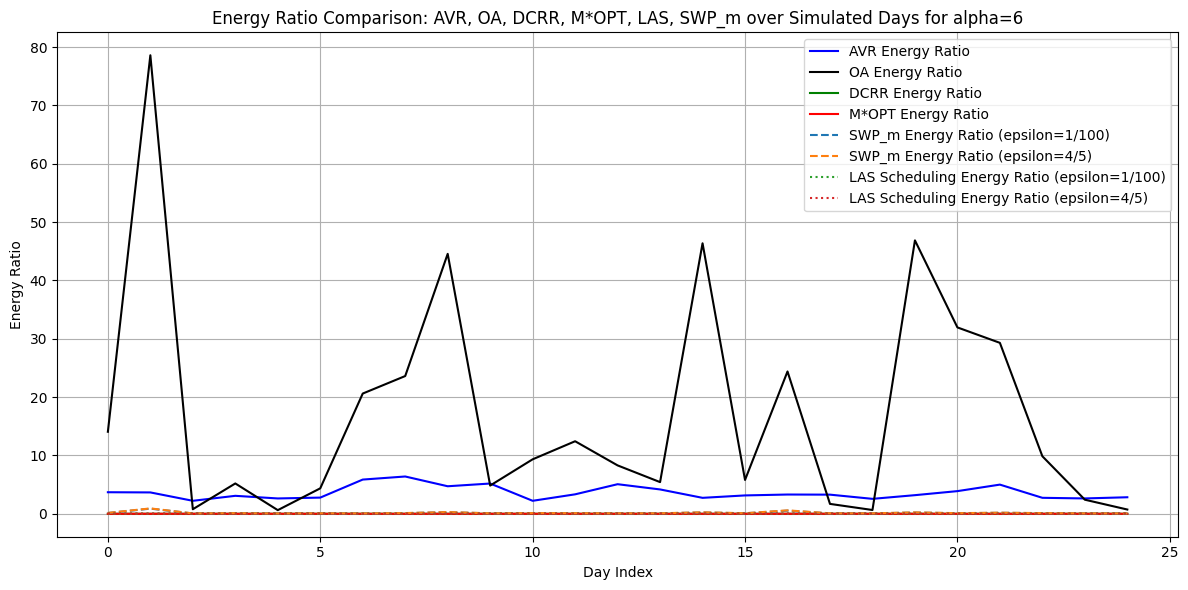

In [43]:
# Create a list of day indices for plotting
day_indices = list(range(len(y_AVR)))

plt.figure(figsize=(12, 6))
plt.plot(day_indices, y_AVR, label='AVR Energy Ratio', color='blue')
plt.plot(day_indices, y_OA, label='OA Energy Ratio', color='black')
plt.plot(day_indices, y_DCRR, label='DCRR Energy Ratio', color='green')
plt.plot(day_indices, y_yds_m, label='M*OPT Energy Ratio', color='red')

# Assuming y_SWP_m is a dictionary with epsilon as keys, and each value is a list of ratios
for epsilon, ratios in y_SWP_m.items():
    plt.plot(day_indices, ratios, label=f'SWP_m Energy Ratio (epsilon={epsilon})', linestyle='--')

for epsilon, ratios in y_LAS.items():
    plt.plot(day_indices, ratios, label=f'LAS Scheduling Energy Ratio (epsilon={epsilon})', linestyle=':')

plt.xlabel('Day Index')
plt.ylabel('Energy Ratio')
plt.title('Energy Ratio Comparison: AVR, OA, DCRR, M*OPT, LAS, SWP_m over Simulated Days for alpha=6')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
y_SWP_m = {}
y_AVR = []
y_OA = []
y_DCRR = []
y_yds_m = []
y_LAS = {}
alpha = alphas[2]
for epsilon in epsilons:
    y_SWP_m[epsilon] = []
    y_LAS[epsilon] = []

for day_idx in dates_lst:
    print(f"day= {day_idx}")
    
    # Use the same day's data for both J_true and J_pred
    raw_day_data = dates_dict[day_idx]
    
    J_pred = create_input(raw_day_data, include_pred_conf=True)
    J_true = create_input(raw_day_data, include_pred_conf=False)

    AVR = AVR_energy_ratio(J_true, alpha)
    OA = OA_energy_ratio(J_true, alpha)
    dcrr_ratio = DCRR_energy_ratio(J_true, m, alpha)
    yds_m_ratio = yds_m_energy_ratio(J_true, m, alpha)
    print("AVG = ", AVR)
    y_AVR.append(AVR)

    print("OA = ", OA)
    y_OA.append(OA)
    
    print("DCRR= ", dcrr_ratio)
    y_DCRR.append(dcrr_ratio)

    print("YDS_m = ", yds_m_ratio)
    y_yds_m.append(yds_m_ratio)
    
    for epsilon in epsilons:
        SWP_m = SWP_m_energy_ratio(J_true, J_pred, m, epsilon, dt, alpha, 0.5)
        LAS_ratio = LAS_energy_ratio(J_true, J_pred, epsilon, alpha, dt)
        print("SWP_m, epsilon=", epsilon, "--->", SWP_m)
        print("LAS Scheduling, epsilon=", epsilon, "--->", LAS_ratio)
        y_SWP_m[epsilon].append(SWP_m)
        y_LAS[epsilon].append(LAS_ratio)
        
    print("====================")


day= 0
AVG =  12.151103420796087
OA =  75.4174606081709
DCRR=  4.4720143313649045e-06
YDS_m =  1.4695554042775622e-06
SWP_m, epsilon= 1/100 ---> 0.04121346559918327
LAS Scheduling, epsilon= 1/100 ---> 0.0053386683436350505
SWP_m, epsilon= 4/5 ---> 0.04717208199616639
LAS Scheduling, epsilon= 4/5 ---> 0.0060567406890672726
day= 1
AVG =  12.183798688192867
OA =  1204.1871692298116
DCRR=  3.1996497317213665e-05
YDS_m =  6.678146910847911e-06
SWP_m, epsilon= 1/100 ---> 1.4059202153042
LAS Scheduling, epsilon= 1/100 ---> 0.00454493231533435
SWP_m, epsilon= 4/5 ---> 1.5202374936383836
LAS Scheduling, epsilon= 4/5 ---> 0.005158329277436066
day= 2
AVG =  4.6879263326093685
OA =  0.7735485475073748
DCRR=  5.589303353910354e-07
YDS_m =  3.989777791084522e-08
SWP_m, epsilon= 1/100 ---> 0.010982603050605555
LAS Scheduling, epsilon= 1/100 ---> 0.007008518133771676
SWP_m, epsilon= 4/5 ---> 0.012537306257208227
LAS Scheduling, epsilon= 4/5 ---> 0.007951191986203905
day= 3
AVG =  9.457028027777444
OA 

In [45]:
print("AVR has mean competitive ratio of :", mean(y_AVR))
print("The worst competitive ratio of AVR is : ", max(y_AVR))

print("OA has mean competitive ratio of :", mean(y_OA))
print("The worst competitive ratio of  OA is : ", max(y_OA))

print("DCRR has mean competitive ratio of :" , mean(y_DCRR))
print("The worst competitive ratio of DCRR is : ", max(y_DCRR))

print("YDS_M has mean competitive ratio of : ", mean(y_yds_m))
print("The worst competitive ratio of YDS_M is : ", max(y_yds_m))
print("==========================================")

for epsilon in epsilons:
    print("LAS for epsilon", epsilon, " has the mean comptitive ratio of :" , mean(y_LAS[epsilon]))
    print("The worst competitive ratio of LAS for epsilon", epsilon, " is : ", max(y_LAS[epsilon]))


    print("SWP_m for epsilon", epsilon, " has the mean comptitive ratio of :" , mean(y_SWP_m[epsilon]))
    print("The worst competitive ratio of SWP_m for epsilon", epsilon, " is : ", max(y_SWP_m[epsilon]))

    print("==============================================")


AVR has mean competitive ratio of : 12.369674736957506
The worst competitive ratio of AVR is :  28.2981483154312
OA has mean competitive ratio of : 158.4134936689523
The worst competitive ratio of  OA is :  1204.1871692298116
DCRR has mean competitive ratio of : 1.3447230382157826e-05
The worst competitive ratio of DCRR is :  0.00010617874988438404
YDS_M has mean competitive ratio of :  3.0301731945511806e-06
The worst competitive ratio of YDS_M is :  3.296411208338982e-05
LAS for epsilon 1/100  has the mean comptitive ratio of : 0.004691341587032463
The worst competitive ratio of LAS for epsilon 1/100  is :  0.007021515918818714
SWP_m for epsilon 1/100  has the mean comptitive ratio of : 0.10806257575769661
The worst competitive ratio of SWP_m for epsilon 1/100  is :  1.4059202153042
LAS for epsilon 4/5  has the mean comptitive ratio of : 0.005333567791496423
The worst competitive ratio of LAS for epsilon 4/5  is :  0.007966359321197127
SWP_m for epsilon 4/5  has the mean comptitive r

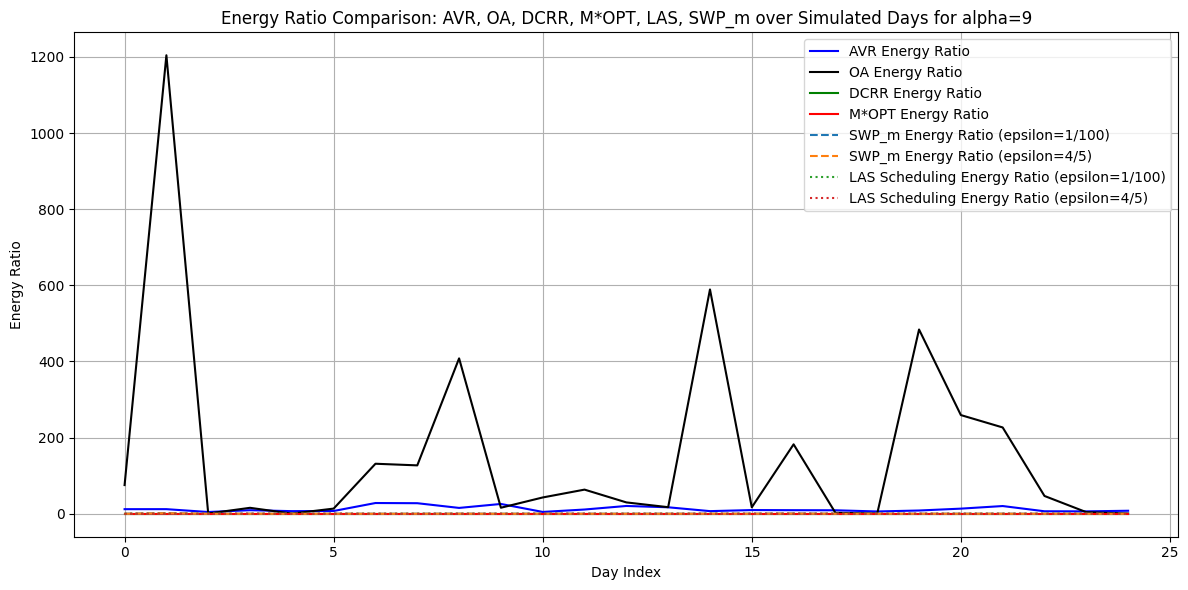

In [46]:
# Create a list of day indices for plotting
day_indices = list(range(len(y_AVR)))

plt.figure(figsize=(12, 6))
plt.plot(day_indices, y_AVR, label='AVR Energy Ratio', color='blue')
plt.plot(day_indices, y_OA, label='OA Energy Ratio', color='black')
plt.plot(day_indices, y_DCRR, label='DCRR Energy Ratio', color='green')
plt.plot(day_indices, y_yds_m, label='M*OPT Energy Ratio', color='red')

# Assuming y_SWP_m is a dictionary with epsilon as keys, and each value is a list of ratios
for epsilon, ratios in y_SWP_m.items():
    plt.plot(day_indices, ratios, label=f'SWP_m Energy Ratio (epsilon={epsilon})', linestyle='--')

for epsilon, ratios in y_LAS.items():
    plt.plot(day_indices, ratios, label=f'LAS Scheduling Energy Ratio (epsilon={epsilon})', linestyle=':')

plt.xlabel('Day Index')
plt.ylabel('Energy Ratio')
plt.title('Energy Ratio Comparison: AVR, OA, DCRR, M*OPT, LAS, SWP_m over Simulated Days for alpha=9')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
y_SWP_m = {}
y_AVR = []
y_OA = []
y_DCRR = []
y_yds_m = []
y_LAS = {}
alpha = alphas[3]
for epsilon in epsilons:
    y_SWP_m[epsilon] = []
    y_LAS[epsilon] = []

for day_idx in dates_lst:
    print(f"day= {day_idx}")
    
    # Use the same day's data for both J_true and J_pred
    raw_day_data = dates_dict[day_idx]
    
    J_pred = create_input(raw_day_data, include_pred_conf=True)
    J_true = create_input(raw_day_data, include_pred_conf=False)

    AVR = AVR_energy_ratio(J_true, alpha)
    OA = OA_energy_ratio(J_true, alpha)
    dcrr_ratio = DCRR_energy_ratio(J_true, m, alpha)
    yds_m_ratio = yds_m_energy_ratio(J_true, m, alpha)
    print("AVG = ", AVR)
    y_AVR.append(AVR)

    print("OA = ", OA)
    y_OA.append(OA)
    
    print("DCRR= ", dcrr_ratio)
    y_DCRR.append(dcrr_ratio)

    print("YDS_m = ", yds_m_ratio)
    y_yds_m.append(yds_m_ratio)
    
    for epsilon in epsilons:
        SWP_m = SWP_m_energy_ratio(J_true, J_pred, m, epsilon, dt, alpha, 0.5)
        LAS_ratio = LAS_energy_ratio(J_true, J_pred, epsilon, alpha, dt)
        print("SWP_m, epsilon=", epsilon, "--->", SWP_m)
        print("LAS Scheduling, epsilon=", epsilon, "--->", LAS_ratio)
        y_SWP_m[epsilon].append(SWP_m)
        y_LAS[epsilon].append(LAS_ratio)
        
    print("====================")


day= 0
AVG =  46.29107278512861
OA =  409.91006976347273
DCRR=  6.592651798865805e-08
YDS_m =  1.3418211481913402e-08
SWP_m, epsilon= 1/100 ---> 0.012338521138650383
LAS Scheduling, epsilon= 1/100 ---> 0.0006960394432546402
SWP_m, epsilon= 4/5 ---> 0.014220580212067973
LAS Scheduling, epsilon= 4/5 ---> 0.0007952973477989032
day= 1
AVG =  46.34812822801482
OA =  18028.286407495896
DCRR=  9.119897778384262e-07
YDS_m =  9.191020146212157e-08
SWP_m, epsilon= 1/100 ---> 2.2601073296815106
LAS Scheduling, epsilon= 1/100 ---> 0.0005283441200343631
SWP_m, epsilon= 4/5 ---> 2.502465873411347
LAS Scheduling, epsilon= 4/5 ---> 0.0006039393663354506
day= 2
AVG =  10.939705042040163
OA =  0.783867127551603
DCRR=  5.917848468310313e-09
YDS_m =  9.376575871530167e-11
SWP_m, epsilon= 1/100 ---> 0.0020658501541385935
LAS Scheduling, epsilon= 1/100 ---> 0.0010889334982749038
SWP_m, epsilon= 4/5 ---> 0.002372548176282834
LAS Scheduling, epsilon= 4/5 ---> 0.0012442196078115756
day= 3
AVG =  34.94483063581

In [48]:
print("AVR has mean competitive ratio of :", mean(y_AVR))
print("The worst competitive ratio of AVR is : ", max(y_AVR))

print("OA has mean competitive ratio of :", mean(y_OA))
print("The worst competitive ratio of  OA is : ", max(y_OA))

print("DCRR has mean competitive ratio of :" , mean(y_DCRR))
print("The worst competitive ratio of DCRR is : ", max(y_DCRR))

print("YDS_M has mean competitive ratio of : ", mean(y_yds_m))
print("The worst competitive ratio of YDS_M is : ", max(y_yds_m))
print("==========================================")

for epsilon in epsilons:
    print("LAS for epsilon", epsilon, " has the mean comptitive ratio of :" , mean(y_LAS[epsilon]))
    print("The worst competitive ratio of LAS for epsilon", epsilon, " is : ", max(y_LAS[epsilon]))


    print("SWP_m for epsilon", epsilon, " has the mean comptitive ratio of :" , mean(y_SWP_m[epsilon]))
    print("The worst competitive ratio of SWP_m for epsilon", epsilon, " is : ", max(y_SWP_m[epsilon]))

    print("==============================================")


AVR has mean competitive ratio of : 50.047984473234735
The worst competitive ratio of AVR is :  153.59416173417452
OA has mean competitive ratio of : 1706.0405687905034
The worst competitive ratio of  OA is :  18028.286407495896
DCRR has mean competitive ratio of : 4.739755557545109e-07
The worst competitive ratio of DCRR is :  4.8185353320544265e-06
YDS_M has mean competitive ratio of :  6.671522112780277e-08
The worst competitive ratio of YDS_M is :  1.0638578667973243e-06
LAS for epsilon 1/100  has the mean comptitive ratio of : 0.0006202444619543936
The worst competitive ratio of LAS for epsilon 1/100  is :  0.0010903916605800956
SWP_m for epsilon 1/100  has the mean comptitive ratio of : 0.12155262362802055
The worst competitive ratio of SWP_m for epsilon 1/100  is :  2.2601073296815106
LAS for epsilon 4/5  has the mean comptitive ratio of : 0.0007098299697755881
The worst competitive ratio of LAS for epsilon 4/5  is :  0.0012459386032979338
SWP_m for epsilon 4/5  has the mean com

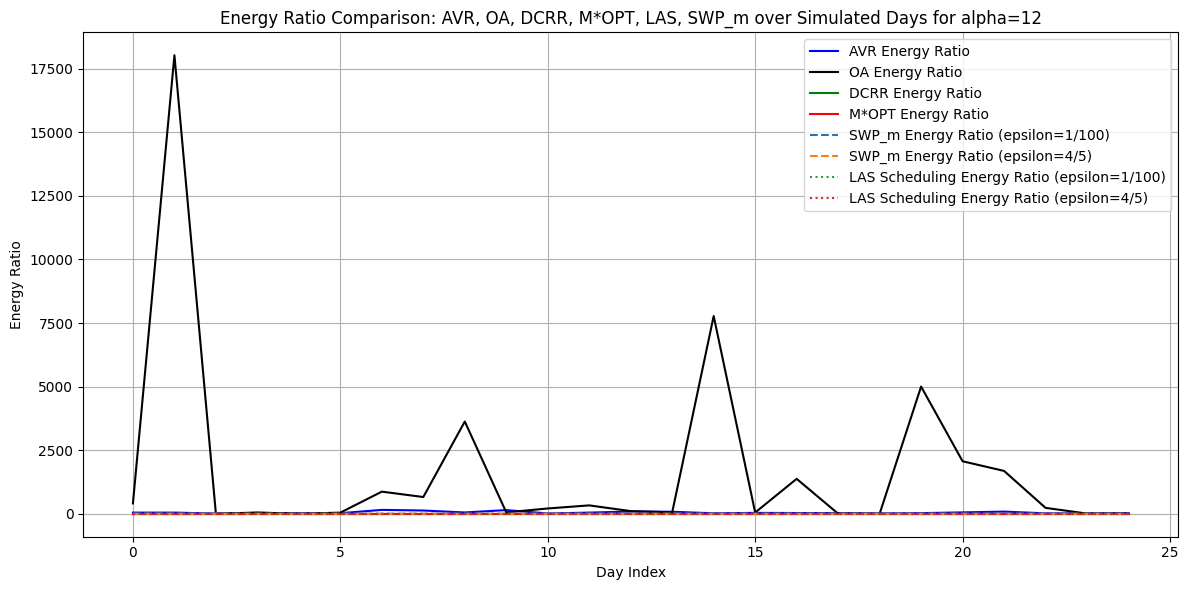

In [49]:
# Create a list of day indices for plotting
day_indices = list(range(len(y_AVR)))

plt.figure(figsize=(12, 6))
plt.plot(day_indices, y_AVR, label='AVR Energy Ratio', color='blue')
plt.plot(day_indices, y_OA, label='OA Energy Ratio', color='black')
plt.plot(day_indices, y_DCRR, label='DCRR Energy Ratio', color='green')
plt.plot(day_indices, y_yds_m, label='M*OPT Energy Ratio', color='red')

# Assuming y_SWP_m is a dictionary with epsilon as keys, and each value is a list of ratios
for epsilon, ratios in y_SWP_m.items():
    plt.plot(day_indices, ratios, label=f'SWP_m Energy Ratio (epsilon={epsilon})', linestyle='--')

for epsilon, ratios in y_LAS.items():
    plt.plot(day_indices, ratios, label=f'LAS Scheduling Energy Ratio (epsilon={epsilon})', linestyle=':')

plt.xlabel('Day Index')
plt.ylabel('Energy Ratio')
plt.title('Energy Ratio Comparison: AVR, OA, DCRR, M*OPT, LAS, SWP_m over Simulated Days for alpha=12')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()